In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/"

 BW_color	    neural_style_0.png	'Занятие сверточные сети'
 BW_person	    neural_style_1.png	 Изображение.psd
'Colab Notebooks'   neural_style_2.png	 Описание.txt
'Data science'	    picasso.jpg		 ОсновыPythonиDataScience.gdoc
 monet.jpg	    ratings.dat
 moscow.jpg	    Segmentation


In [3]:
# import tensorflow as tf

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [22]:
import time
from keras.preprocessing.image import load_img, img_to_array
#from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

In [23]:
import imageio
from tqdm import tqdm

In [24]:
from keras.applications import vgg19
from keras import backend as K

## Исходные изображения и параметры алгоритма

In [25]:
CONTENT_IMG_PATH = '/content/drive/My Drive/moscow.jpg'
STYLE_IMG_PATH = '/content/drive/My Drive/picasso.jpg'

ITERATIONS = 3  # число итераций
STYLE_WEIGHT = 0.5  # веса функции потерь стиля
CONTENT_WEIGHT = 0.75  # вес функции потерь содержимого
VARIATION_WEIGHT = 0.99  # вес функции потерь разницы между соседними пикселами

## Задаем размеры выходного изображения

In [26]:
width, height = load_img(CONTENT_IMG_PATH).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Визуализируем исходные изображения

Text(0.5, 1.0, 'Content Image')

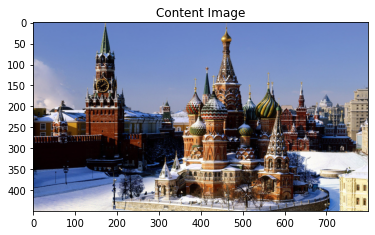

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(plt.imread(CONTENT_IMG_PATH))
plt.title('Content Image')

Text(0.5, 1.0, 'Style Image - Monet')

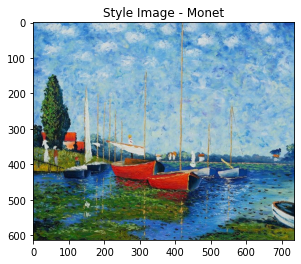

In [28]:
plt.imshow(plt.imread('/content/drive/My Drive/monet.jpg'))
plt.title('Style Image - Monet')

Text(0.5, 1.0, 'Style Image - Picasso')

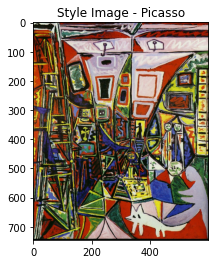

In [29]:
plt.imshow(plt.imread('/content/drive/My Drive/picasso.jpg'))
plt.title('Style Image - Picasso')

In [30]:
# препроцессинг изображения для отправки в сеть vgg19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# преобразуем сгенерированный тензор в изображение
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # возвращаем смещение относительно среднего
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# загружаем изображения и подготоваливаем к прогону через vgg
base_image = K.variable(preprocess_image(CONTENT_IMG_PATH))
style_reference_image = K.variable(preprocess_image(STYLE_IMG_PATH))

# создаем буфер для сохранения результирующего изображения
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# объединяем изображения в батч
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# загружаем предобученную сеть
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# словарь выходов слоев
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [31]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 400, 711, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 711, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 711, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 355, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 355, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 355, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 177, 128)        0     

## Задаем функцию потерь

In [32]:
# матрица ковариации
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# функция потерь стиля вычисляется на основе матрицы ковариации
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# функция потерь для содержания
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# накладываем ограничение на похожесть соседних пикселей
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Объединяем функции потерь

In [33]:
loss = K.variable(0.)

# контент вычисляем только для слоя 'block5_conv2'
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + CONTENT_WEIGHT * content_loss(base_image_features, combination_features)

# функцию потерь стиля вычисляем на всех сверточных слоях
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (STYLE_WEIGHT / len(feature_layers)) * sl
    
# добавляем функцию потерь на похожесть соседних пикселей
loss = loss + VARIATION_WEIGHT * total_variation_loss(combination_image)

## Градиенты полученного изображения от функции потерь

In [34]:
from tensorflow.python.framework.ops import disable_eager_execution #tf.compat.v1.disable_eager_execution() # отключение немедленного исполнения
# градиенты считаются автоматически по правилу дифференцирования сложной функции
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# вычисляем функцию потерь и градиенты
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# обертка для класса оптимизатора
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Запускаем процесс стилизации изображения

In [35]:
# инициализируем исходным изображением
x = preprocess_image(CONTENT_IMG_PATH)

for i in tqdm(range(ITERATIONS)):
    print('Start of iteration', i)
    start_time = time.time()
    # вычисляем градиент и обновляем значения
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # сохраняем сгенерированное изображение
    img = deprocess_image(x.copy())
    fname = '/content/drive/My Drive/neural_style_%d.png' % i
    imageio.imwrite(fname, img)
    #imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

  0%|          | 0/3 [00:00<?, ?it/s]

Start of iteration 0
Current loss value: 11361438000.0


 33%|███▎      | 1/3 [00:45<01:30, 45.38s/it]

Image saved as /content/drive/My Drive/neural_style_0.png
Iteration 0 completed in 45s
Start of iteration 1
Current loss value: 8492228600.0


 67%|██████▋   | 2/3 [00:55<00:34, 34.92s/it]

Image saved as /content/drive/My Drive/neural_style_1.png
Iteration 1 completed in 10s
Start of iteration 2
Current loss value: 7566142500.0


100%|██████████| 3/3 [01:06<00:00, 22.21s/it]

Image saved as /content/drive/My Drive/neural_style_2.png
Iteration 2 completed in 10s


## Результат

Text(0.5, 1.0, 'Monet 0')

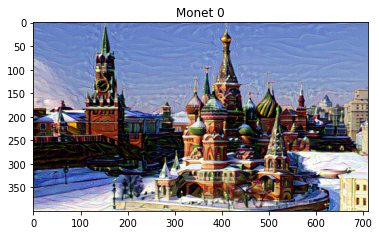

In [36]:
plt.imshow(plt.imread('/content/drive/My Drive/neural_style_0.png'))
plt.title('Monet 0')

Text(0.5, 1.0, 'Monet 1')

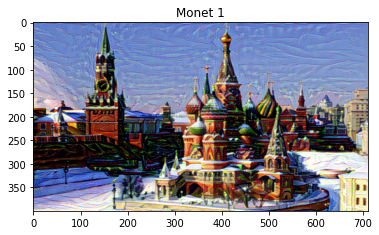

In [37]:
plt.imshow(plt.imread('/content/drive/My Drive/neural_style_1.png'))
plt.title('Monet 1')

Text(0.5, 1.0, 'Monet 2')

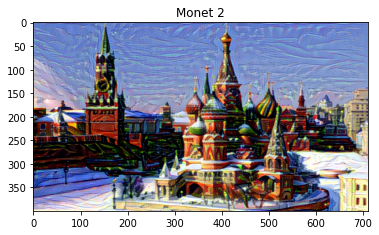

In [38]:
plt.imshow(plt.imread('/content/drive/My Drive/neural_style_2.png'))
plt.title('Monet 2')

In [ ]:
plt.imshow(plt.imread('/content/drive/My Drive/styled_picasso_0.png'))
plt.title('Picasso 0')

In [ ]:
plt.imshow(plt.imread('/content/drive/My Drive/styled_picasso_1.png'))
plt.title('Picasso 1')